In [1]:
from state import State
import os
import json
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from utils.order_parameters import (
    calculate_var_r,
    potential_M_N,
    angular_distance,
    calculate_S,
    centroid_m
)
import colorsys
from matplotlib.ticker import MultipleLocator

RESULTS_DIR = 'results_processing/fetched/'

In [2]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['legend.fancybox'] = True
#print(plt.rcParams.find_all('axes'))

plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.edgecolor'] = '#b3b3b3'
#plt.rcParams['figure.framealpha'] = 0.5
#plt.tick_params(left=False, bottom=False)
#matplotlib.style.use('default')
#matplotlib.style.use('seaborn-talk')
#matplotlib.style.use('seaborn-whitegrid')


In [3]:
robot_names = os.listdir(RESULTS_DIR)
experiments = {
    robot_name: os.listdir(os.path.join(RESULTS_DIR, robot_name, 'log'))
    for robot_name in robot_names
}

def filter_valid_experiment_names(experiment_names):
    result = {
        name[:20] for name in experiment_names
        if name.startswith('2020-07-06')
    }
    return result


experiment_names_iter = iter(experiments.values())
common_experiments = filter_valid_experiment_names(set(next(experiment_names_iter)))
common_experiments = common_experiments.intersection(
    *[filter_valid_experiment_names(set(data)) for data in experiment_names_iter]
)

def state_from_json(s, params):
    #print(s)
    params.update({
        'phase_levels_number': s['phase_levels_number'],
        'orientation_mode': s['orientation_mode'],
    })
    state = State(
        phase=s['phase'],
        position=np.array(s['position']),
        #phase_level=s['phase_level'],
        #phase_levels_number=s['phase_levels_number'],
        #small_phase=s['small_phase'],
        velocity=np.array(s['velocity']),
        #orientation_mode=s['orientation_mode'],
        params=params,
    )
    state.phase_level = s['phase_level']
    return state

def parse_params_from_filename(filename):
    params = {}
    param_string = filename[:-5].split(':')[-1]
    param_strings = param_string.split(',')
    for ps in param_strings:
        param_name, value_string = ps.split('=')
        if param_name == 'M':
            value = int(value_string)
        else:
            value = float(value_string)
        params[param_name] = value
    return params

def get_experiment_raw_data(experiment_name_prefix):
    result = {}
    for robot_name in robot_names:
        full_experiment_name = [
            name
            for name in os.listdir(os.path.join(RESULTS_DIR, robot_name, 'log'))
            if name.startswith(experiment_name_prefix)
        ][0]
        with open(os.path.join(RESULTS_DIR, robot_name, 'log', full_experiment_name)) as f:
            result[robot_name] = json.load(f)
        params = parse_params_from_filename(full_experiment_name)
    return result, params

def get_plot_data(experiments_data, params):
    states = {}
    result = {
        'var_rs': [],
        'Ss': [],
        'centroids': [],
        'snapshots': [],
        'ts': {},
        'params': params
    }
    
    for drone_name, drone_data in experiments_data.items():
        data = drone_data['states']
        ts = [d[0] for d in data]
        result['ts'][drone_name] = [t-ts[0] for t in ts]
        states[drone_name] = [state_from_json(list(s[1].values())[0], params) for s in data]
        
    #print(states)
        
    
    states_matrix = list(zip(*list(states.values())))
    phases = [
        [s.phase_level / s.phase_levels_number for s in current_states]
        for current_states in states_matrix
    ]
    result['var_rs'] = [calculate_var_r(current_states) for current_states in states_matrix]       
    result['Ss'] = [calculate_S(current_states) for current_states in states_matrix]       
    result['centroids'] = [centroid_m(1, ps) for ps in phases] 
    result['snapshots'] = states
    return result






In [4]:
order_params = {}
for experiment_name_prefix in common_experiments:
    print(experiment_name_prefix)
    try:
        data, params = get_experiment_raw_data(experiment_name_prefix)
        plot_data = get_plot_data(data, params)
        order_params[experiment_name_prefix] = plot_data
    except (ValueError, TypeError):
        continue
    

2020-07-06 16:16:09.
2020-07-06 14:36:43.
2020-07-06 16:26:44.
2020-07-06 17:13:31.
2020-07-06 16:42:56.
2020-07-06 16:52:51.
2020-07-06 15:51:52.
2020-07-06 12:09:03.
2020-07-06 16:46:44.


/home/agniewek/repos/nav/swarmalatorbot_aws/base_station/ros2_overlay_ws/src/robot_framework/robot_framework/utils/order_parameters.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  positions = np.array([s.position for s in states])


2020-07-06 17:26:53.
2020-07-06 16:20:00.
2020-07-06 12:12:49.
2020-07-06 16:23:24.
2020-07-06 12:26:25.


In [6]:
patterns = {
    #'static-async': '2020-07-06 17:13:31.',
    #'static-sync': '2020-07-06 15:51:52.',
    'static-phase-wave': '2020-07-06 16:20:00.',
    #'splintered-phase-wave': '2020-07-06 16:23:24.'
}

data_end = {
    'static-async': -1,
    'static-sync': -1,
    'static-phase-wave': 800,
    'splintered-phase-wave': -1,
}

instants = {}
#tmp = list(order_params[patterns['static-sync']]['ts'].values())[0][:data_end['static-sync']]
#instants['static-sync'] = [0, int(len(tmp)/2)%4, -1]
#tmp = list(order_params[patterns['static-async']]['ts'].values())[0][:data_end['static-async']]
#instants['static-async'] = [0, int(len(tmp)/2), -1]
tmp = list(order_params[patterns['static-phase-wave']]['ts'].values())[0][:data_end['static-phase-wave']]
instants['static-phase-wave'] = [0, int(len(tmp)/3)-2, data_end['static-phase-wave']]
#tmp = list(order_params[patterns['splintered-phase-wave']]['ts'].values())[0][:data_end['splintered-phase-wave']]
#instants['splintered-phase-wave'] = [0, int(len(tmp)/2), -1]




2020-07-06 16:20:00. {'J': 1.5, 'K': 1.0, 'M': 8, 'phase_levels_number': 24, 'orientation_mode': True}
1538


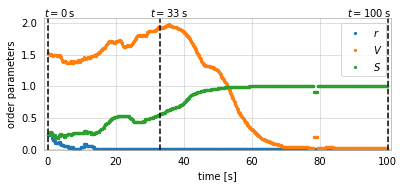

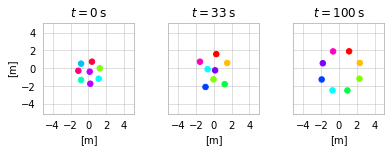

In [34]:
for pattern_name, experiment_name_prefix in patterns.items():
    data = order_params[experiment_name_prefix]
    print(experiment_name_prefix, data['params'])
    times = list(data['ts'].values())[:data_end[pattern_name]]
    min_len = min(len(ts) for ts in times)
    if any(abs(len(ts) - min_len) > 1 for ts in times):
        print('difference too high')
        continue
    for i, ts in enumerate(times):
        if len(ts) == min_len + 1:
            times[i] = ts[:-1]     
    if not (all(ts==times[0] for ts in times)):
        print([(len(t), t[0], t[-1]) for t in times])
        continue
    fig, ax = plt.subplots(
        1, 1, sharex=True, constrained_layout=True, figsize=(5.5, 2.5)
    )
    #fig.suptitle(f"{experiment_name_prefix} {data['params']}")


    #fig.suptitle(filename)
    fig2, s = plt.subplots(1, 3, constrained_layout=True, figsize=(5.5, 2), sharex=True, sharey=True)
    #print(len(times[0]), len(data['centroids']), len(data['var_rs']), len(data['Ss']))

    ax.set_axisbelow(True)
    ax.scatter(times[0][:data_end[pattern_name]], data['centroids'][:data_end[pattern_name]], s=5, label="$r$")
    ax.scatter(times[0][:data_end[pattern_name]], data['var_rs'][:data_end[pattern_name]], s=5, label="$V$")
    ax.scatter(times[0][:data_end[pattern_name]], data['Ss'][:data_end[pattern_name]], s=5, label="$S$")
    #ax.scatter(ts[filename], angular_distances[filename], s=5, label="Angular distance diff")
    #ax.scatter(ts[filename], time_coord_potentials[filename], s=5, label="Time coordination potential")
    #ax.spines['left'].set_visible(False)
    ax.set_ylim(ymin=-0.01)
    offsets = [times[0][data_end[pattern_name]]*0.01, times[0][data_end[pattern_name]]*0.03, times[0][data_end[pattern_name]]*0.12]
    snapshots = list(zip(*list(data['snapshots'].values())))
    print(len(snapshots))
    #print(snapshots)
    
    for i, idx in enumerate(instants[pattern_name]):

        t = times[0][idx]
        ax.axvline(t, color='black', ls='--')
        ax.text(t-offsets[i], 1.01, f'$t={t:.0f}\\:$s', transform=ax.get_xaxis_transform())
        s[i].xaxis.set_major_locator(MultipleLocator(2))
        s[i].yaxis.set_major_locator(MultipleLocator(2))
        s[i].set_aspect('equal')
        # print(data['snapshots'])
        #print(snapshots[i])
        xs = [s.position[0] for s in snapshots[idx]]
        ys = [s.position[1] for s in snapshots[idx]]
        cs = [colorsys.hsv_to_rgb(s.phase, 1, 1) for s in snapshots[idx]]
        s[i].set_axisbelow(True)
        s[i].set_xlim((-5.1, 5.1))
        s[i].set_ylim((-5.1, 5.1))
        s[i].scatter(xs, ys, c=cs, s=30)
        s[i].set_title(f'$t={t:.0f}\\:$s')
        s[i].set_xlabel('[m]')
        
    s[0].set_ylabel('[m]')

    ax.legend(loc='upper right')
    ax.set_xlim((-times[0][data_end[pattern_name]]*0.01, times[0][data_end[pattern_name]]*1.01))
    ax.set_xlabel('time [s]')
    ax.set_ylabel('order parameters')
    fig.savefig(f'/home/agniewek/repos/papers/2020-journal/data/exp-op-balboa-{pattern_name}.pdf', transparent=True, bbox_inches="tight")
    fig2.savefig(f'/home/agniewek/repos/papers/2020-journal/data/exp-snapshots-balboa-{pattern_name}.pdf', transparent=True, bbox_inches="tight")
    
    
    
    #fig, (ax_var_rs, ax_S, ax_ang_dist, ax_time_coord, ax_centroid) = plt.subplots(
    #    5, 1, sharex=True, constrained_layout=True, figsize=(5, 10)
    #)
    #fig.suptitle(filename)

    #ax_var_rs.scatter(ts[filename], var_rs[filename])
    #ax_S.scatter(ts[filename], Ss[filename])
    #ax_ang_dist.scatter(ts[filename], angular_distances[filename])
    #ax_time_coord.scatter(ts[filename], time_coord_potentials[filename])
    #ax_centroid.scatter(ts[filename], centroids[filename])
    
    #ax_var_rs.set_ylim(ymin=0)
    #ax_S.set_ylim(ymin=0)
    #ax_ang_dist.set_ylim(ymin=0)
    #ax_time_coord.set_ylim(ymin=0)
    #ax_centroid.set_ylim(ymin=0)
    
    #ax_var_rs.set_title("Distance from middle diff")
    #ax_S.set_title("S")
    #ax_ang_dist.set_title("Angular distance diff")
    #ax_time_coord.set_title("Time coordination potential")
    #ax_centroid.set_title("Synchronization centroid")